# Studying Time Series using Dynamic Time Warping

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the data

In [2]:
data = pd.read_csv('data.csv')
data = data.drop(['Unnamed: 0'], axis=1)
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

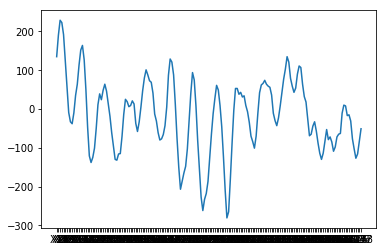

In [3]:
# Let's print an example
plt.plot(X.iloc[0,:])
plt.show()

## DTW Algorithm

In [4]:
def DTW(x, y, c=lambda x,y: abs(x-y), verbose=False, **kwargs):
    '''Using the Bellman recursion, compute the Dynamic Time Warping distance between x and y with a cost function c, assuming x and y have the same dimension.'''
    
    assert x.shape[0] == y.shape[0]
    n = x.shape[0]
    
    ### Cost retrieval ###
    if 'precomputed' in kwargs: # The cost matrix is precomputed
        C = kwargs['precomputed']
        assert C.shape == (n,n)
    else: # Compute the cost matrix
        C = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                C[i,j] = c(x[i], y[j])
    
    if verbose:
        print('Cost\n', C)
    
    # Bellman variables
    r = np.zeros((n,n))
    r[0,0] = C[0,0]
    
    ### For each diagonal 'k', run the Bellman recursion ###
    
    # First half of the square
    for k in range(1,n):
        for i in range(k+1):
            j = k-i
            if i == 0: # First line
                r[i,j] = C[i,j] + r[i, j-1]
            elif j == 0: # First column
                r[i,j] = C[i,j] + r[i-1, j]
            else:
                r[i,j] = C[i,j] + np.min([r[i-1, j-1], r[i-1, j], r[i, j-1]])
    
    # Second half of the square
    for k in range(n,2*n-1):
        #print(k, k+1-n, n)
        for i in range(k+1-n, n):
            j = k-i
            if i == 0: # First line
                r[i,j] = C[i,j] + r[i, j-1]
            elif j == 0: # First column
                r[i,j] = C[i,j] + r[i-1, j]
            else:
                r[i,j] = C[i,j] + np.min([r[i-1, j-1], r[i-1, j], r[i, j-1]])
    
    if verbose:
        print('Bellman\n',r)        
    
    return r[-1,-1]

Let's compute an example of DTW :

In [5]:
x_1 = X.iloc[0,:]
x_2 = X.iloc[1,:]
DTW(x_1, x_2, verbose=True)

Cost
 [[251. 247. 221. ...  19.   8.   6.]
 [196. 192. 166. ...  36.  47.  61.]
 [157. 153. 127. ...  75.  86. 100.]
 ...
 [502. 498. 472. ... 270. 259. 245.]
 [469. 465. 439. ... 237. 226. 212.]
 [437. 433. 407. ... 205. 194. 180.]]
Bellman
 [[  251.   498.   719. ... 57690. 57698. 57704.]
 [  447.   443.   609. ... 56581. 56628. 56689.]
 [  604.   596.   570. ... 56392. 56478. 56578.]
 ...
 [70812. 70112. 65588. ... 53614. 53714. 53800.]
 [71281. 70577. 66027. ... 53740. 53840. 53926.]
 [71718. 71010. 66434. ... 53834. 53934. 54020.]]


54020.0

## A 3-Nearest-Neighbors classifier using DTW

Because DTW is computationnally-heavy to run, we only train the 3-NN on 50 time series, and test in on 10 time series.

In [79]:
X_train = X.iloc[:50,:]
y_train = y.iloc[:50]

X_test = X.iloc[-10:,:]
y_test = y.iloc[-10:]

In [80]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3, metric=DTW, n_jobs=-1)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function DTW at 0x7efbbf1226a8>, metric_params=None,
           n_jobs=-1, n_neighbors=3, p=2, weights='uniform')

In [81]:
# Prediction for the 10 test time series using DTW metric
pred = neigh.predict(X_test)

In [82]:
# Prediction for the 10 test time series using L2 metric
neigh_ = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
neigh_.fit(X_train, y_train)
pred_ = neigh_.predict(X_test)

In [83]:
print('Correct predictions using DTW loss :', 100.*np.sum(pred==y_test)/y_test.shape[0], '%')
print('Correct predictions using l2 loss :', 100.*np.sum(pred_==y_test)/y_test.shape[0], '%')

Correct predictions using DTW loss : 60.0 %
Correct predictions using l2 loss : 30.0 %


Although the train and test datasets are very small, it seems that classification is easier when using the DTW metric (rather than the L2 metric).

## Projection of the time series in 2D

Let us select randomly 5 time series by label, which corresponds to $5\times5 = 25$ time series in total. For those 25 time series, we compute the DTW distance matrix.
300 time series would have been too long to compute.

In [86]:
data_1 = data.loc[data.loc[:,'y'] == 1, :].sample(frac=1.).iloc[:5,:]
data_2 = data.loc[data.loc[:,'y'] == 2, :].sample(frac=1.).iloc[:5,:]
data_3 = data.loc[data.loc[:,'y'] == 3, :].sample(frac=1.).iloc[:5,:]
data_4 = data.loc[data.loc[:,'y'] == 4, :].sample(frac=1.).iloc[:5,:]
data_5 = data.loc[data.loc[:,'y'] == 5, :].sample(frac=1.).iloc[:5,:]
data_proj = pd.concat([data_1, data_2, data_3, data_4, data_5])
data_proj = data_proj.sample(frac=1.)

In [87]:
N = 5*5
Distance = np.zeros((N,N))
for i in range(N):
    for j in range(i+1,N):
        Distance[i,j] = DTW(data_proj.iloc[i,:], data_proj.iloc[j,:])
        Distance[j,i] = Distance[i,j]
        print(i,j,Distance[i,j])

0 1 7785.0
0 2 13185.0
0 3 12271.0
0 4 8584.0
0 5 9922.0
0 6 12143.0
0 7 22367.0
0 8 12332.0
0 9 8338.0
0 10 21042.0
0 11 39820.0
0 12 13155.0
0 13 23961.0
0 14 11358.0
0 15 8281.0
0 16 11336.0
0 17 10747.0
0 18 7142.0
0 19 13635.0
0 20 7950.0
0 21 13658.0
0 22 10948.0
0 23 49261.0
0 24 7085.0
1 2 7888.0
1 3 8231.0
1 4 6514.0
1 5 5933.0
1 6 7365.0
1 7 18454.0
1 8 8581.0
1 9 4633.0
1 10 19345.0
1 11 41967.0
1 12 7847.0
1 13 26336.0
1 14 6860.0
1 15 7409.0
1 16 6629.0
1 17 6555.0
1 18 6491.0
1 19 7172.0
1 20 5388.0
1 21 7405.0
1 22 5671.0
1 23 53574.0
1 24 6753.0
2 3 9996.0
2 4 7087.0
2 5 4980.0
2 6 4504.0
2 7 25372.0
2 8 2824.0
2 9 4705.0
2 10 22057.0
2 11 53874.0
2 12 3004.0
2 13 35384.0
2 14 4411.0
2 15 6996.0
2 16 3926.0
2 17 6996.0
2 18 12605.0
2 19 3431.0
2 20 5872.0
2 21 2709.0
2 22 5496.0
2 23 59915.0
2 24 10664.0
3 4 7264.0
3 5 8312.0
3 6 9020.0
3 7 16131.0
3 8 12388.0
3 9 8533.0
3 10 28364.0
3 11 44852.0
3 12 7395.0
3 13 27463.0
3 14 6681.0
3 15 8576.0
3 16 8331.0
3 17 6345.0
3

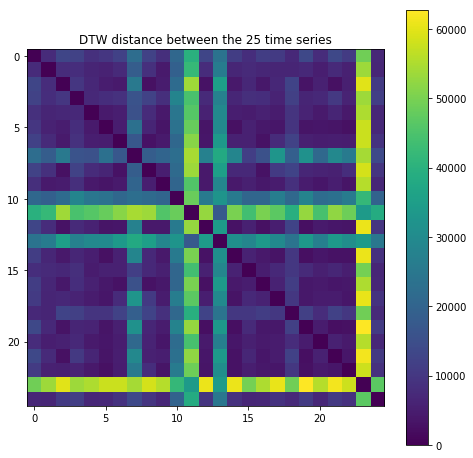

In [136]:
plt.figure(figsize=(8,8))
plt.imshow(Distance)
plt.colorbar()
plt.title('DTW distance between the 25 time series')
plt.show()

Let us use the DTW distances to represent the time series in 2D, using MDS and t-SNE algorithms.

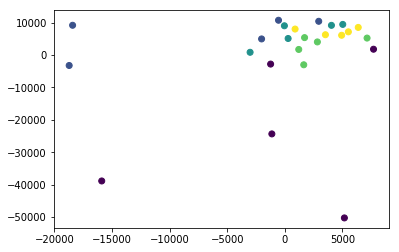

In [98]:
from sklearn.manifold import MDS

proj_mds = MDS(dissimilarity='precomputed').fit(Distance)
plt.scatter(proj_mds.embedding_[:,0], proj_mds.embedding_[:,1], c=data_proj.iloc[:N,-1])
plt.show()

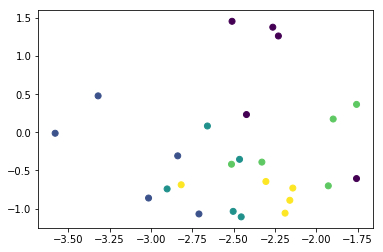

In [92]:
from sklearn.manifold import TSNE

proj_tsne = TSNE(perplexity=20, early_exaggeration=12, learning_rate=10, metric='precomputed').fit(Distance)
plt.scatter(proj_tsne.embedding_[:,0], proj_tsne.embedding_[:,1], c=data_proj.iloc[:N,-1])
plt.show()

Points from similar classes tend to be represented by points that are closer to each other, for both MDS and t-SNE algorithms. Still, the representation is not perfect and separate clusters do not appear.

## DTW Barycenters

Let us compute the DTW Barycenters and the L2 barycenters for data from the five different classes.

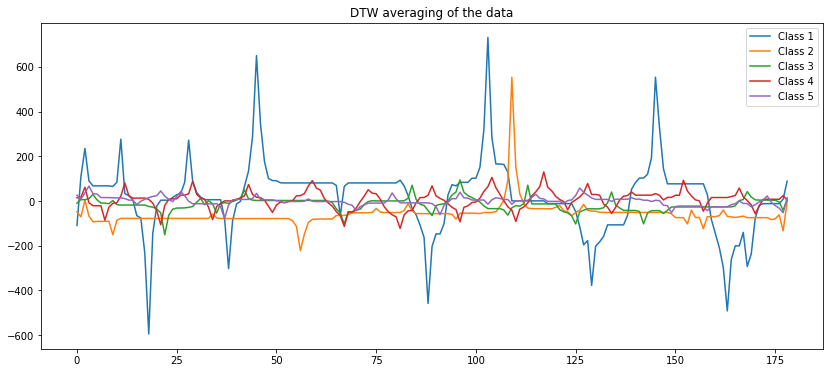

In [135]:
from tslearn.barycenters import dtw_barycenter_averaging

barycenter_1 = dtw_barycenter_averaging(np.array(data_1))
barycenter_2 = dtw_barycenter_averaging(np.array(data_2))
barycenter_3 = dtw_barycenter_averaging(np.array(data_3))
barycenter_4 = dtw_barycenter_averaging(np.array(data_4))
barycenter_5 = dtw_barycenter_averaging(np.array(data_5))

plt.figure(figsize=(14,6))

plt.title('DTW averaging of the data')

plt.plot(barycenter_1, label='Class 1')
plt.plot(barycenter_2, label='Class 2')
plt.plot(barycenter_3, label='Class 3')
plt.plot(barycenter_4, label='Class 4')
plt.plot(barycenter_5, label='Class 5')

plt.legend()
plt.show()

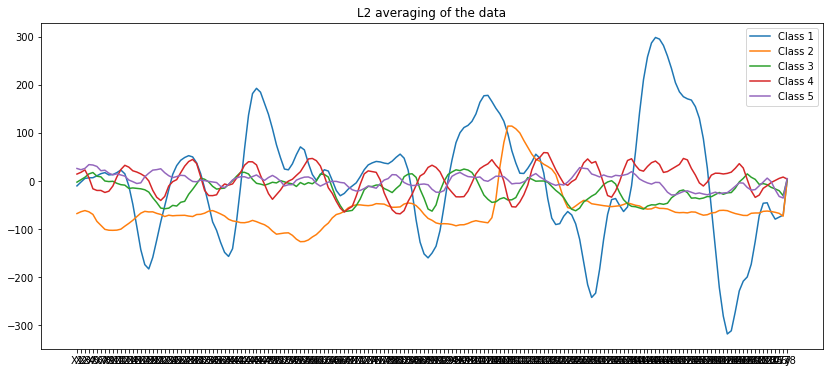

In [134]:
barycenter_l2_1 = data_1.mean(axis=0)
barycenter_l2_2 = data_2.mean(axis=0)
barycenter_l2_3 = data_3.mean(axis=0)
barycenter_l2_4 = data_4.mean(axis=0)
barycenter_l2_5 = data_5.mean(axis=0)

plt.figure(figsize=(14,6))

plt.title('L2 averaging of the data')

plt.plot(barycenter_l2_1, label='Class 1')
plt.plot(barycenter_l2_2, label='Class 2')
plt.plot(barycenter_l2_3, label='Class 3')
plt.plot(barycenter_l2_4, label='Class 4')
plt.plot(barycenter_l2_5, label='Class 5')

plt.legend()
plt.show()

The DTW barycenters tend to have peaks, while L2 barycenters are smoother. The five different classes tend to have very different typical behaviours.